In [50]:
import osmnx as ox
import geopandas as gpd

from shapely.geometry import Point
ox.settings.use_cache=True
ox.settings.log_console=True

### Demonstration
We want to find the nearest edge to the centroids of all polygons representing the PA fields in the north-east region of Costa Rica.

First we demonstrate the process using a single point near Pital

In [78]:
%%time
# lat (y) lon(x) points

xlon =  -84.278967
ylat = 10.476319
point = ylon, xlat  # center of PA field near Pital

G = ox.graph_from_point(point, network_type='all_private', dist=5000)

# project the graph (and point) to a meter projection
Gp = ox.project_graph(G)

point_geom_proj, crs = ox.projection.project_geometry(Point(reversed(point)), to_crs=Gp.graph['crs'])
x, y = point_geom_proj.x, point_geom_proj.y


Wall time: 4.12 s


In [82]:
%%time
# find nearest edge as (u, v, key) and distance to it
test, dist = ox.nearest_edges(Gp, Y=y, X=x, return_dist=True)

Wall time: 280 ms


In [86]:
#convert u,v,key to list
unique_edges = [test]
unique_edges

[(9859123657, 1684148002, 0)]

We also get the distance from the centroid to the edge (street) in meters. This will be used to penalize for transportation within the field

In [88]:
dist.round(2)

177.58

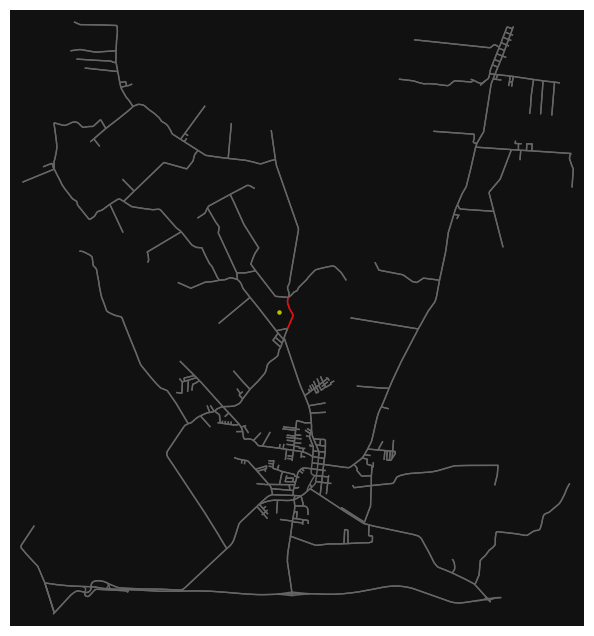

In [81]:
# In yellow is the centoid, in red we see the nearest steet to the centroid
ec = ['r' if e in unique_edges else '#666666' for e in G.edges]
fig, ax = ox.plot_graph(G, edge_color=ec, edge_linewidth=1, node_size=0, show=False)
ax = ax.scatter(xlon,ylat,c='y', s=5, zorder=-1)

### Now we perform the same calculations with all pineapple fields centroids 

In [93]:
## path to PA fields and network
pal = r'C:\Users\isaldiviagonzatti\Downloads/gitFiles/MScThesisCode/FLP/output/ northPAL.gpkg'
networkFile = r'C:\Users\isaldiviagonzatti\Downloads\gitFiles/MScThesisCode/FLP/output/cr_allPrivate.gpkg'

In [94]:
palPoint = gpd.read_file(pal)

In [100]:
#define lon, lat points
xlon=palPoint['geometry'].x
ylat=palPoint['geometry'].y

In [96]:
#load road network
gdf_nodes = gpd.read_file(networkFile, layer='nodes').set_index('osmid')
gdf_edges = gpd.read_file(networkFile, layer='edges').set_index(['u', 'v', 'key'])
assert gdf_nodes.index.is_unique and gdf_edges.index.is_unique

In [102]:
# convert the node/edge GeoDataFrames to a MultiDiGraph
graph_attrs = {'crs': 'epsg:4326', 'simplified': True}
G = ox.graph_from_gdfs(gdf_nodes, gdf_edges, graph_attrs)

In [106]:
G_proj = ox.project_graph(G)

In [108]:
# project graph and points to same CRS
geom = gpd.points_from_xy(xlon, ylat)
gdf = gpd.GeoDataFrame(palPoint, crs='epsg:4326').to_crs(G_proj.graph['crs'])

In [116]:
%%time
# calculate nearest edge to each point
nePAL = ox.nearest_edges(G_proj, X=gdf['geometry'].x, Y=gdf['geometry'].y, interpolate=10, return_dist=True)

Wall time: 0 ns


In [132]:
edgesPAL = nePAL[0]
distPAL = nePAL[1]

Let's see how far is the farest centroid from its corresponding street:

In [134]:
print(max(distPAL), 'meters')

2329.8036268984774 meters


In [125]:
unique_edges = set(edgesPAL)

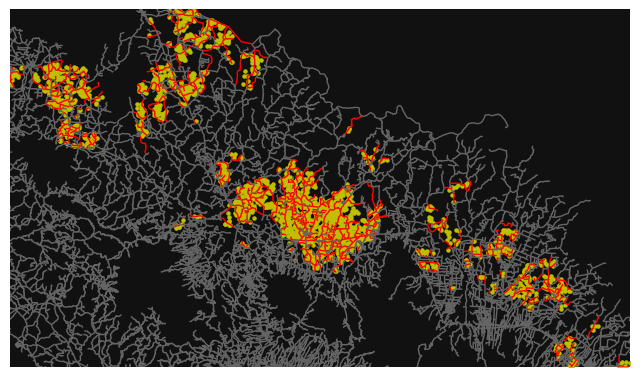

In [130]:
ec = ['r' if e in unique_edges else '#666666' for e in G.edges]
fig, ax = ox.plot_graph(G, edge_color=ec, edge_linewidth=1, node_size=0, show=False, bbox=(11.04681261,10.09956058,-83.40407159,-85.07389766))
ax = ax.scatter(xlon, ylat, c='y', s=5, zorder=-1)

Let's look at the area from the demonstration

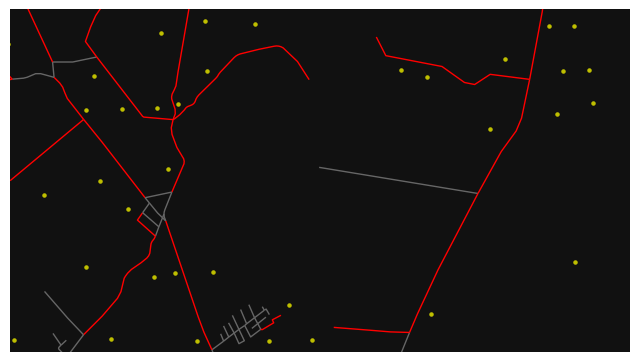

In [131]:
ec = ['r' if e in unique_edges else '#666666' for e in G.edges]
fig, ax = ox.plot_graph(G, edge_color=ec, edge_linewidth=1, node_size=0, show=False, bbox=(10.4854,10.4637,-84.2482,-84.2881))
ax = ax.scatter(xlon, ylat, c='y', s=5, zorder=-1)

now join the edges and distances with the initial PAL dataset containing the area
Then we create regular grid whose points will be used as candidate locations
Finally, we create optimization algorithm using tonnes of PAL, distance from centroid to edge to calculate costs of extraction; candidates will carry the costs of opening and running processing plant; finally we use estimates of transport costs